In [1]:
import psutil
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta


import matplotlib
matplotlib.use("Agg")

np.random.seed(42)

## 1. read raw data 

In [2]:
data_folder = Path("./data/raw_data/")

In [3]:
train_series = pd.read_parquet(data_folder/"train_series.parquet")
train_events = pd.read_csv(data_folder/"train_events.csv")

In [4]:
train_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [5]:
train_events

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400
...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06T04:07:00-0400
14504,fe90110788d2,34,onset,574620.0,2017-09-06T23:35:00-0400
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07T09:17:00-0400
14506,fe90110788d2,35,onset,NaN,NaN


## 2. Preprocessing data

### 2.1 Sampling Accelerometer Data

In [6]:
series_ids = train_series['series_id'].unique()
num_val_series_ids = round(0.2 * len(series_ids))
series_ids_in_val = np.random.choice(series_ids, size=num_val_series_ids, replace=False)
train_rows = train_series.loc[~ train_series['series_id'].isin(series_ids_in_val)].reset_index(drop=True)
train_series['large_enmo'] = train_series['enmo'] > np.percentile(train_rows['enmo'], 95)

### 2.2 Extract features from onset to wake up.

#### 2.2.1 Original Data

In [7]:
raw_series = train_series.loc[train_series['series_id'] == series_ids[0]].reset_index(drop=True)
raw_series

,series_id,step,timestamp,anglez,enmo,large_enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,False
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,False
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,False
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,False
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,False
...,...,...,...,...,...,...
389875,038441c925bb,389875,2018-09-06T04:59:35-0400,-27.373899,0.0110,False
389876,038441c925bb,389876,2018-09-06T04:59:40-0400,-27.493799,0.0110,False
389877,038441c925bb,389877,2018-09-06T04:59:45-0400,-27.533701,0.0111,False
389878,038441c925bb,389878,2018-09-06T04:59:50-0400,-28.003599,0.0111,False


In [11]:
raw_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389880 entries, 0 to 389879
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   series_id   389880 non-null  object 
 1   step        389880 non-null  uint32 
 2   timestamp   389880 non-null  object 
 3   anglez      389880 non-null  float32
 4   enmo        389880 non-null  float32
 5   large_enmo  389880 non-null  bool   
dtypes: bool(1), float32(2), object(2), uint32(1)
memory usage: 10.8+ MB


#### 2.2.2 An example of one day signal

In [16]:
s = raw_series['timestamp'].astype(str)
one_day_series = raw_series[s.str.startswith("2018-08-14")]
one_day_series

,series_id,step,timestamp,anglez,enmo,large_enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217,False
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215,False
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216,False
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213,False
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215,False
...,...,...,...,...,...,...
6115,038441c925bb,6115,2018-08-14T23:59:35-0400,-71.811699,0.0169,False
6116,038441c925bb,6116,2018-08-14T23:59:40-0400,-71.811699,0.0167,False
6117,038441c925bb,6117,2018-08-14T23:59:45-0400,-71.811699,0.0167,False
6118,038441c925bb,6118,2018-08-14T23:59:50-0400,-71.811699,0.0172,False


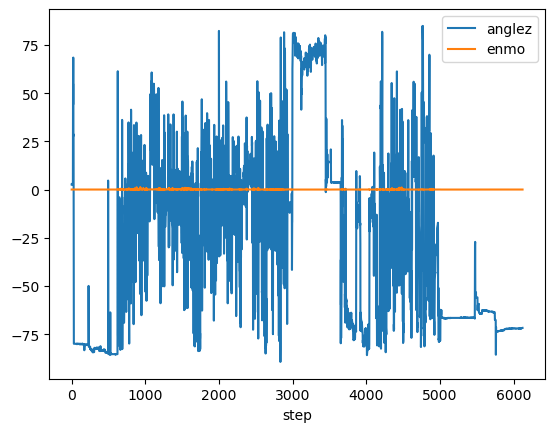

In [17]:

one_day_series.plot(x = 'step', y = ["anglez", "enmo"])

In [19]:
one_day_properties = []
all_events = []
for i in range(len(series_ids)):
# for i in range(1):
    # print("i:", i)
    # print("series_id:", series_ids[i])
    series = train_series.loc[train_series['series_id'] == series_ids[i]].reset_index(drop=True)
    series['color'] = ["blue" if large_enmo else "green" for large_enmo in series['large_enmo']]
    series['timestamp'] = pd.to_datetime(series['timestamp'])
    series['timestamp_utc'] = series['timestamp'].map(lambda timestamp: timestamp.astimezone(timezone.utc))
    series['anglez_radians'] = (np.pi / 180) * series['anglez']
    series['cos_anglez'] = np.cos(series['anglez_radians'])
    series['enmo'] = np.clip(series['enmo'], 0, 1)
    min_date_utc = series['timestamp_utc'].dt.date.min()
    max_date_utc = series['timestamp_utc'].dt.date.max()
    series_24_hour_windows = {}
    upper_bound = datetime(year=min_date_utc.year, month=min_date_utc.month, day=min_date_utc.day, hour=20, minute=30, tzinfo=timezone.utc)
    lower_bound = upper_bound + timedelta(hours=-24) # 8:30pm UTC on the previous day.
    while lower_bound < series['timestamp_utc'].max():
        window_df = series.loc[(series['timestamp_utc'] >= lower_bound) & (series['timestamp_utc'] < upper_bound)].reset_index(drop=True)
        if len(window_df) > 0:
            series_24_hour_windows[upper_bound.isoformat()[:-6]] = window_df
        upper_bound += timedelta(hours=24)
        lower_bound += timedelta(hours=24)

    events = train_events.loc[train_events['series_id'] == series_ids[i]].reset_index(drop=True)
    events = events.loc[events['timestamp'].notna()].reset_index(drop=True)
    events['timestamp'] = pd.to_datetime(events['timestamp'])
    events['timestamp_utc'] = events['timestamp'].map(lambda timestamp: timestamp.astimezone(timezone.utc))
    events_24_hour_windows = {}
    upper_bound = datetime(year=min_date_utc.year, month=min_date_utc.month, day=min_date_utc.day, hour=20, minute=30, tzinfo=timezone.utc)
    lower_bound = upper_bound + timedelta(hours=-24) # 8:30pm UTC on the previous day.
    while lower_bound < series['timestamp_utc'].max():
        window_df = events.loc[(events['timestamp_utc'] >= lower_bound) & (events['timestamp_utc'] < upper_bound)].reset_index(drop=True)
        if len(window_df) > 0:
            events_24_hour_windows[upper_bound.isoformat()[:-6]] = window_df
        upper_bound += timedelta(hours=24)
        lower_bound += timedelta(hours=24)
    
    windows = list(series_24_hour_windows.keys())
    num_steps_cumulative = 0
    for window_idx, window in enumerate(windows):        
        fig = plt.figure(figsize=(14.4, 4))  # (width, height) in inches
        plt.plot(series_24_hour_windows[window]['timestamp_utc'], series_24_hour_windows[window]['cos_anglez'], color="red")
        plt.scatter(
            series_24_hour_windows[window]['timestamp_utc'], 
            series_24_hour_windows[window]['enmo'], 
            color=series_24_hour_windows[window]['color'], 
            s=1
        )
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.margins(0, 0)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        time = window.replace(":", "_")
        plt.savefig(Path("./data/images") / f"{series_ids[i]}_{time}.jpg", bbox_inches="tight", pad_inches=0)
        # plt.savefig(path.abspath(images_folder + str(series_ids[i]) + str(window) + ".jpg"), bbox_inches="tight", pad_inches=0)
        plt.clf()
        plt.cla()
        plt.close()

        min_ts_window = series_24_hour_windows[window]['timestamp_utc'].min()
        max_ts_window = series_24_hour_windows[window]['timestamp_utc'].max()
        num_steps_window = (max_ts_window - min_ts_window).total_seconds() / 5 + 1
        num_steps_cumulative += num_steps_window
        one_day_properties.append({
            'series_id': series_ids[i], 
            'image_name': f"{series_ids[i]}_{time}.jpg", 
            'idx_in_series': window_idx, 
            'num_steps_window': num_steps_window, 
            'num_steps_cumulative': num_steps_cumulative
        })

        events_window = []
        if window in events_24_hour_windows:
            for j in range(len(events_24_hour_windows[window])):
                event = {}
                event['series_id'] = series_ids[i]
                event['image_name'] = f"{series_ids[i]}_{time}.jpg"
                row = events_24_hour_windows[window].iloc[j]
                event['label'] = row['event']
                event['step_in_series'] = row['step']
                event_ts = row['timestamp_utc']
                event['step_in_window'] = (event_ts - min_ts_window).total_seconds() / 5
                event['x0'] = round((event['step_in_window'] / num_steps_window) * 1440) - 20
                event['y0'] = 20
                event['x1'] = round((event['step_in_window'] / num_steps_window) * 1440) + 20
                event['y1'] = 380
                events_window.append(event)
        all_events.extend(events_window)
    print("% of RAM used:", psutil.virtual_memory().percent)

i: 0
series_id: 038441c925bb
% of RAM used: 86.0


## 3. Save Processed Data

In [23]:
one_day_properties = pd.DataFrame(one_day_properties)
annotations_df = pd.DataFrame(all_events)

In [25]:
one_day_properties.to_csv("./data/processed_data/one_day_properties.csv", index=False)
annotations_df.to_csv("./data/processed_data/annotations_cutoff.csv", index=False)

In [27]:
one_day_properties[one_day_properties["series_id"] == "038441c925bb"]

,series_id,image_name,idx_in_series,num_steps_window,num_steps_cumulative
0,038441c925bb,038441c925bb_2018-08-14T20_30_00.jpg,0,720.0,720.0
1,038441c925bb,038441c925bb_2018-08-15T20_30_00.jpg,1,17280.0,18000.0
2,038441c925bb,038441c925bb_2018-08-16T20_30_00.jpg,2,17280.0,35280.0
3,038441c925bb,038441c925bb_2018-08-17T20_30_00.jpg,3,17280.0,52560.0
4,038441c925bb,038441c925bb_2018-08-18T20_30_00.jpg,4,17280.0,69840.0
5,038441c925bb,038441c925bb_2018-08-19T20_30_00.jpg,5,17280.0,87120.0
6,038441c925bb,038441c925bb_2018-08-20T20_30_00.jpg,6,17280.0,104400.0
7,038441c925bb,038441c925bb_2018-08-21T20_30_00.jpg,7,17280.0,121680.0
8,038441c925bb,038441c925bb_2018-08-22T20_30_00.jpg,8,17280.0,138960.0
9,038441c925bb,038441c925bb_2018-08-23T20_30_00.jpg,9,17280.0,156240.0


In [26]:
annotations_df[annotations_df["series_id"] == "038441c925bb"]

,series_id,image_name,label,step_in_series,step_in_window,x0,y0,x1,y1
0,038441c925bb,038441c925bb_2018-08-15T20_30_00.jpg,onset,4992.0,4272.0,336,20,376,380
1,038441c925bb,038441c925bb_2018-08-15T20_30_00.jpg,wakeup,10932.0,10212.0,831,20,871,380
2,038441c925bb,038441c925bb_2018-08-16T20_30_00.jpg,onset,20244.0,2244.0,167,20,207,380
3,038441c925bb,038441c925bb_2018-08-16T20_30_00.jpg,wakeup,27492.0,9492.0,771,20,811,380
4,038441c925bb,038441c925bb_2018-08-17T20_30_00.jpg,onset,39996.0,4716.0,373,20,413,380
5,038441c925bb,038441c925bb_2018-08-17T20_30_00.jpg,wakeup,44400.0,9120.0,740,20,780,380
6,038441c925bb,038441c925bb_2018-08-18T20_30_00.jpg,onset,57240.0,4680.0,370,20,410,380
7,038441c925bb,038441c925bb_2018-08-18T20_30_00.jpg,wakeup,62856.0,10296.0,838,20,878,380
8,038441c925bb,038441c925bb_2018-08-20T20_30_00.jpg,onset,91296.0,4176.0,328,20,368,380
9,038441c925bb,038441c925bb_2018-08-20T20_30_00.jpg,wakeup,97860.0,10740.0,875,20,915,380
